In [1]:
%cd ../

/home/users/dmoreno2016/ASTROMER/astromer_pe_main/astromer/presentation/experiments/astromer_1_pe


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import glob
import toml
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

In [3]:
pretraining_path = 'results/pretraining/P02R01_clean/exp_005_a'
finetuning_path = 'results/finetuning/P02R01_clean/exp_005_a'

datasets_names = ['alcock', 'atlas', 'ogle']
subsets = [500]
folds = [0, 1, 2]

In [4]:
#datasets_names = ['kepler', 'kepler_alcock_linear', 'kepler_atlas_linear', 'kepler_ogle_linear']
#subsets = ['all']

datasets_names = ['alcock', 'atlas', 'ogle', 'kepler', 'kepler_alcock_linear', 'kepler_atlas_linear', 'kepler_ogle_linear']
subsets = [50]

In [5]:
## Pretraining metrics
dict_logs_pretraining = dict()

for subset_name in subsets:
    if subset_name != 'all':
        path_metrics = os.path.join(pretraining_path, 'test_metrics_datasets_{}.toml'.format(subset_name))
    else:
        path_metrics = os.path.join(pretraining_path, 'test_metrics_datasets.toml')

    with open(path_metrics, 'r') as f:
        dict_logs_pretraining['{}'.format(subset_name)] = toml.load(f)

In [6]:
dict_logs_pretraining

{'50': {'alcock': {'fold_0': {'loss': 0.16192235052585602,
    'r_square': 0.5452542901039124,
    'rmse': 0.16192235052585602},
   'fold_1': {'loss': 0.13689781725406647,
    'r_square': 0.5791913866996765,
    'rmse': 0.13689781725406647},
   'fold_2': {'loss': 0.1541844755411148,
    'r_square': 0.5762009024620056,
    'rmse': 0.1541844755411148}},
  'ogle': {'fold_0': {'loss': 0.13734064996242523,
    'r_square': 0.6328490972518921,
    'rmse': 0.13734064996242523},
   'fold_1': {'loss': 0.13410532474517822,
    'r_square': 0.6341578960418701,
    'rmse': 0.13410532474517822},
   'fold_2': {'loss': 0.1427118331193924,
    'r_square': 0.6310020685195923,
    'rmse': 0.1427118331193924}},
  'atlas': {'fold_0': {'loss': 0.1911723017692566,
    'r_square': 0.6013091206550598,
    'rmse': 0.1911723017692566},
   'fold_1': {'loss': 0.19298842549324036,
    'r_square': 0.5523098111152649,
    'rmse': 0.19298842549324036},
   'fold_2': {'loss': 0.18994921445846558,
    'r_square': 0.600387

In [7]:
dict_pt_metrics = {
    'r2': [],
    'rmse': [],
    'time_epoch': [],
    'time_batch': [],
}

In [8]:
for subset in subsets:
    df_r2, df_rmse, df_time_epoch, df_time_batch = [], [], [], []
    for ds_name in datasets_names:            
        
        list_r2, list_rmse, list_time_epoch, list_time_batch = [], [], [], []
        for fold in folds:
            list_r2.append(dict_logs_pretraining['{}'.format(subset)][ds_name]['fold_{}'.format(fold)]['r_square'])
            list_rmse.append(dict_logs_pretraining['{}'.format(subset)][ds_name]['fold_{}'.format(fold)]['rmse'])
            list_time_epoch.append(0)
            list_time_batch.append(0)
            
        df_r2.append(pd.DataFrame({ds_name: list_r2}))
        df_rmse.append(pd.DataFrame({ds_name: list_rmse}))
        df_time_epoch.append(pd.DataFrame({ds_name: list_time_epoch}))
        df_time_batch.append(pd.DataFrame({ds_name: list_time_batch}))

    dict_pt_metrics['r2'] = pd.concat(df_r2, axis=1)
    dict_pt_metrics['rmse'] = pd.concat(df_rmse, axis=1)
    dict_pt_metrics['time_epoch'] = pd.concat(df_time_epoch, axis=1)
    dict_pt_metrics['time_batch'] = pd.concat(df_time_batch, axis=1)

In [9]:
for metric_name, dict_results in dict_pt_metrics.items():
    dict_results['fold'] = folds
    dict_results['Trainable layers'] = ['Without FT' for _ in folds]
    dict_pt_metrics['{}'.format(metric_name)] = dict_results

In [10]:
dict_pt_metrics

{'r2':      alcock     atlas      ogle    kepler  kepler_alcock_linear  \
 0  0.545254  0.601309  0.632849 -0.135306              0.401631   
 1  0.579191  0.552310  0.634158 -0.135268              0.418218   
 2  0.576201  0.600388  0.631002 -0.136494              0.413493   
 
    kepler_atlas_linear  kepler_ogle_linear  fold Trainable layers  
 0             0.411806            0.417046     0       Without FT  
 1             0.402896            0.431385     1       Without FT  
 2             0.408651            0.405672     2       Without FT  ,
 'rmse':      alcock     atlas      ogle    kepler  kepler_alcock_linear  \
 0  0.161922  0.191172  0.137341  0.049766              0.040720   
 1  0.136898  0.192988  0.134105  0.049803              0.042192   
 2  0.154184  0.189949  0.142712  0.049809              0.041216   
 
    kepler_atlas_linear  kepler_ogle_linear  fold Trainable layers  
 0             0.041380            0.040045     0       Without FT  
 1             0.041082

## Extract finetuning metrics

In [11]:
## Finetuning metrics

dict_logs_finetuning = dict()
for path_lr_files in glob.glob('{}/*'.format(finetuning_path)):
    lr = path_lr_files.split('/')[-1]

    dict_logs_finetuning[lr] = dict()
    for path_science_cases in glob.glob('{}/*'.format(path_lr_files)):
        spc = path_science_cases.split('/')[-1]

        dict_logs_finetuning[lr][spc] = dict()
        for path_ds_name in glob.glob('{}/*'.format(path_science_cases)):
            ds_name = path_ds_name.split('/')[-1]

            if ds_name in datasets_names:

                dict_logs_finetuning[lr][spc][ds_name] = dict()
                for path_fold in glob.glob('{}/*'.format(path_ds_name)):
                    fold_name = path_fold.split('/')[-1]

                    dict_logs_finetuning[lr][spc][ds_name][fold_name] = dict()
                    for path_subsets in glob.glob('{}/*'.format(path_fold)):
                        #print(path_subsets)
                        subset_name = path_subsets.split('/')[-1]

                        #if subset_name.split('_')[-1] in subsets:
                        
                        with open(os.path.join(path_subsets, 'test_metrics.toml'), 'r') as f:
                            metrics = toml.load(f)

                        dict_logs_finetuning[lr][spc][ds_name][fold_name][subset_name] = dict()
                        #for files in ['metrics', 'time_epoch', 'time_batch']:
                        dict_logs_finetuning[lr][spc][ds_name][fold_name][subset_name]['metrics'] = metrics
                        dict_logs_finetuning[lr][spc][ds_name][fold_name][subset_name]['time_batch'] = pd.read_csv(os.path.join(path_subsets, 'time_batch.csv'))
                        dict_logs_finetuning[lr][spc][ds_name][fold_name][subset_name]['time_epoch'] = pd.read_csv(os.path.join(path_subsets, 'time_epoch.csv'))


FileNotFoundError: [Errno 2] No such file or directory: 'results/finetuning/P02R01_clean/exp_005_a/lr_scheduler/FF1_PE_ATT_FF2/kepler_atlas_linear/fold_1/kepler_atlas_linear_50/test_metrics.toml'

In [14]:
lr = 'lr_scheduler_pe_by_mean'

In [15]:
dict_ft_metrics = {
    'r2': [],
    'rmse': [],
    'time_epoch': [],
    'time_batch': [],
}

for subset in subsets:

    for i, idx_name in enumerate(list(dict_logs_finetuning[lr].keys())):

        df_r2, df_rmse, df_time_epoch, df_time_batch = [], [], [], []
        for ds_name in datasets_names:            

            list_r2, list_rmse, list_time_epoch, list_time_batch = [], [], [], []
            for fold in folds:
                try:

                    if subset != 'all':
                        list_r2.append(dict_logs_finetuning[lr][idx_name][ds_name]['fold_{}'.format(fold)]['{}_{}'.format(ds_name, subset)]['metrics']['test_r_square'])
                        list_rmse.append(dict_logs_finetuning[lr][idx_name][ds_name]['fold_{}'.format(fold)]['{}_{}'.format(ds_name, subset)]['metrics']['test_rmse'])
                        list_time_epoch.append(dict_logs_finetuning[lr][idx_name][ds_name]['fold_{}'.format(fold)]['{}_{}'.format(ds_name, subset)]['time_epoch'].time_epoch.values.sum())
                        list_time_batch.append(dict_logs_finetuning[lr][idx_name][ds_name]['fold_{}'.format(fold)]['{}_{}'.format(ds_name, subset)]['time_batch'].time_batch.values.sum())

                    else:
                        list_r2.append(dict_logs_finetuning[lr][idx_name][ds_name]['fold_{}'.format(fold)]['{}'.format(ds_name)]['metrics']['test_r_square'])
                        list_rmse.append(dict_logs_finetuning[lr][idx_name][ds_name]['fold_{}'.format(fold)]['{}'.format(ds_name)]['metrics']['test_rmse'])
                        list_time_epoch.append(dict_logs_finetuning[lr][idx_name][ds_name]['fold_{}'.format(fold)]['{}'.format(ds_name)]['time_epoch'].time_epoch.values.sum())
                        list_time_batch.append(dict_logs_finetuning[lr][idx_name][ds_name]['fold_{}'.format(fold)]['{}'.format(ds_name)]['time_batch'].time_batch.values.sum())

                except: 
                    print('We do not have fold {} ({})'.format(fold, ds_name))
                    
            df_r2.append(pd.DataFrame({ds_name: list_r2}))
            df_rmse.append(pd.DataFrame({ds_name: list_rmse}))
            df_time_epoch.append(pd.DataFrame({ds_name: list_time_epoch}))
            df_time_batch.append(pd.DataFrame({ds_name: list_time_batch}))

        dict_ft_metrics['r2'].append(pd.concat(df_r2, axis=1))
        dict_ft_metrics['rmse'].append(pd.concat(df_rmse, axis=1))
        dict_ft_metrics['time_epoch'].append(pd.concat(df_time_epoch, axis=1))
        dict_ft_metrics['time_batch'].append(pd.concat(df_time_batch, axis=1))

        for metric_name, dict_results in dict_ft_metrics.items():
            dict_results[i]['fold'] = folds
            dict_results[i]['Trainable layers'] = ['{}'.format(idx_name) for _ in folds]
            dict_ft_metrics['{}'.format(metric_name)][i] = dict_results[i]
        
    for metric_name, _ in dict_ft_metrics.items():
        dict_ft_metrics[metric_name] = pd.concat(dict_ft_metrics[metric_name])


In [16]:
dict_ft_metrics['r2']

,alcock,atlas,ogle,kepler,kepler_alcock_linear,kepler_atlas_linear,kepler_ogle_linear,fold,Trainable layers
0,0.659515,0.533182,0.696162,-13.775835,0.679381,0.615128,0.642406,0,PE
1,0.732335,0.518831,0.708281,-2.855016,0.677106,0.629872,0.564089,1,PE
2,0.713083,0.512204,0.695856,-3.358970,0.679446,0.628655,0.639354,2,PE
0,0.674785,0.593487,0.716491,0.432233,0.705256,0.712161,0.706465,0,FF1_PE_ATT_FF2
1,0.738660,0.569263,0.714005,0.690084,0.710576,0.589310,0.706956,1,FF1_PE_ATT_FF2
2,0.725450,0.577725,0.717172,0.478555,0.709486,0.622387,0.716833,2,FF1_PE_ATT_FF2
0,0.676253,0.606995,0.727113,0.602333,0.735068,0.678344,0.736310,0,FF1_ATT_FF2
1,0.744171,0.587787,0.729059,0.686133,0.721428,0.645800,0.713680,1,FF1_ATT_FF2
2,0.722037,0.583930,0.720494,0.666402,0.721178,0.701890,0.727707,2,FF1_ATT_FF2
0,0.670086,0.545961,0.571153,-1.000668,0.659889,0.606940,0.620226,0,FF1_PE


## RMSE v/s Finetuning time

In [17]:
import seaborn as sns

In [18]:
set_layers_trainable = dict_ft_metrics['r2']['Trainable layers'].unique()

In [19]:
dict_results = {
    'Time training': [],
    'R^2 (PT)': [],
    'R^2 (FT)': [],
    u'Δ R^2 (FT - PT)': [],
    'RMSE (PT)': [],
    'RMSE (FT)': [],
    u'Δ RMSE (PT - FT)': [],
    'Dataset name': [],
    'Trainable layers': [],
    'Fold':[]
}

for dataset_name in datasets_names:

    for layers_trainable in set_layers_trainable:        

        for fold in folds:

            pt_r2_fold = dict_pt_metrics['r2'][dict_pt_metrics['r2'].fold == fold]
            pt_r2_fold_layers = pt_r2_fold[pt_r2_fold['Trainable layers'] == 'Without FT']

            pt_rmse_fold = dict_pt_metrics['rmse'][dict_pt_metrics['rmse'].fold == fold]
            pt_rmse_fold_layers = pt_rmse_fold[pt_rmse_fold['Trainable layers'] == 'Without FT']

            ##################################################################################################

            ft_time_fold = dict_ft_metrics['time_epoch'][dict_ft_metrics['time_epoch'].fold == fold]
            ft_time_fold_layers = ft_time_fold[ft_time_fold['Trainable layers'] == layers_trainable]

            ft_r2_fold = dict_ft_metrics['r2'][dict_ft_metrics['r2'].fold == fold]
            ft_r2_fold_layers = ft_r2_fold[ft_r2_fold['Trainable layers'] == layers_trainable]

            ft_rmse_fold = dict_ft_metrics['rmse'][dict_ft_metrics['rmse'].fold == fold]
            ft_rmse_fold_layers = ft_rmse_fold[ft_rmse_fold['Trainable layers'] == layers_trainable]

            ##################################################################################################

            dict_results['Time training'].append(ft_time_fold_layers[dataset_name].iloc[0])
            
            dict_results['R^2 (PT)'].append(pt_r2_fold_layers[dataset_name].iloc[0])
            dict_results['R^2 (FT)'].append(ft_r2_fold_layers[dataset_name].iloc[0])
            dict_results[u'Δ R^2 (FT - PT)'].append(ft_r2_fold_layers[dataset_name].iloc[0] \
                                                - pt_r2_fold_layers[dataset_name].iloc[0])
            
            dict_results['RMSE (PT)'].append(pt_rmse_fold_layers[dataset_name].iloc[0])
            dict_results['RMSE (FT)'].append(ft_rmse_fold_layers[dataset_name].iloc[0])
            dict_results[u'Δ RMSE (PT - FT)'].append(pt_rmse_fold_layers[dataset_name].iloc[0] \
                                                - ft_rmse_fold_layers[dataset_name].iloc[0])

            dict_results['Dataset name'].append(dataset_name.upper())
            dict_results['Trainable layers'].append(layers_trainable)
            dict_results['Fold'].append(fold)

df_results = pd.DataFrame(dict_results)
df_results

,Time training,R^2 (PT),R^2 (FT),Δ R^2 (FT - PT),RMSE (PT),RMSE (FT),Δ RMSE (PT - FT),Dataset name,Trainable layers,Fold
0,34.235014,0.644710,0.659515,0.014804,0.142652,0.138077,0.004574,ALCOCK,PE,0
1,25.360709,0.735943,0.732335,-0.003607,0.108520,0.108567,-0.000047,ALCOCK,PE,1
2,31.304678,0.732545,0.713083,-0.019461,0.124953,0.123739,0.001214,ALCOCK,PE,2
3,37.353526,0.644710,0.674785,0.030074,0.142652,0.132400,0.010252,ALCOCK,FF1_PE_ATT_FF2,0
4,30.292532,0.735943,0.738660,0.002717,0.108520,0.107924,0.000596,ALCOCK,FF1_PE_ATT_FF2,1
...,...,...,...,...,...,...,...,...,...,...
79,66.623674,0.670759,0.713680,0.042922,0.030648,0.028727,0.001921,KEPLER_OGLE_LINEAR,FF1_ATT_FF2,1
80,72.718249,0.652573,0.727707,0.075134,0.030971,0.028092,0.002879,KEPLER_OGLE_LINEAR,FF1_ATT_FF2,2
81,33.937006,0.641412,0.620226,-0.021186,0.031111,0.031825,-0.000714,KEPLER_OGLE_LINEAR,FF1_PE,0
82,31.917765,0.670759,0.675313,0.004554,0.030648,0.030597,0.000051,KEPLER_OGLE_LINEAR,FF1_PE,1


In [20]:
df_results = df_results.dropna().reset_index(drop=True)
df_results

,Time training,R^2 (PT),R^2 (FT),Δ R^2 (FT - PT),RMSE (PT),RMSE (FT),Δ RMSE (PT - FT),Dataset name,Trainable layers,Fold
0,34.235014,0.644710,0.659515,0.014804,0.142652,0.138077,0.004574,ALCOCK,PE,0
1,25.360709,0.735943,0.732335,-0.003607,0.108520,0.108567,-0.000047,ALCOCK,PE,1
2,31.304678,0.732545,0.713083,-0.019461,0.124953,0.123739,0.001214,ALCOCK,PE,2
3,37.353526,0.644710,0.674785,0.030074,0.142652,0.132400,0.010252,ALCOCK,FF1_PE_ATT_FF2,0
4,30.292532,0.735943,0.738660,0.002717,0.108520,0.107924,0.000596,ALCOCK,FF1_PE_ATT_FF2,1
...,...,...,...,...,...,...,...,...,...,...
79,66.623674,0.670759,0.713680,0.042922,0.030648,0.028727,0.001921,KEPLER_OGLE_LINEAR,FF1_ATT_FF2,1
80,72.718249,0.652573,0.727707,0.075134,0.030971,0.028092,0.002879,KEPLER_OGLE_LINEAR,FF1_ATT_FF2,2
81,33.937006,0.641412,0.620226,-0.021186,0.031111,0.031825,-0.000714,KEPLER_OGLE_LINEAR,FF1_PE,0
82,31.917765,0.670759,0.675313,0.004554,0.030648,0.030597,0.000051,KEPLER_OGLE_LINEAR,FF1_PE,1


In [21]:
df_pt_results = df_results.drop_duplicates(subset=['R^2 (PT)'])
df_pt_results['Trainable layers'] = 'Pretraining'
df_pt_results['R^2 (FT)'] = df_pt_results['R^2 (PT)']
df_pt_results

/tmp/ipykernel_29852/552464588.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pt_results['Trainable layers'] = 'Pretraining'
/tmp/ipykernel_29852/552464588.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pt_results['R^2 (FT)'] = df_pt_results['R^2 (PT)']


,Time training,R^2 (PT),R^2 (FT),Δ R^2 (FT - PT),RMSE (PT),RMSE (FT),Δ RMSE (PT - FT),Dataset name,Trainable layers,Fold
0,34.235014,0.644710,0.644710,0.014804,0.142652,0.138077,0.004574,ALCOCK,Pretraining,0
1,25.360709,0.735943,0.735943,-0.003607,0.108520,0.108567,-0.000047,ALCOCK,Pretraining,1
2,31.304678,0.732545,0.732545,-0.019461,0.124953,0.123739,0.001214,ALCOCK,Pretraining,2
12,19.141749,0.592113,0.592113,-0.058931,0.201257,0.270721,-0.069465,ATLAS,Pretraining,0
13,52.026354,0.591662,0.591662,-0.072831,0.189360,0.256988,-0.067628,ATLAS,Pretraining,1
14,30.849814,0.562295,0.562295,-0.050091,0.206956,0.281352,-0.074395,ATLAS,Pretraining,2
24,39.354156,0.720503,0.720503,-0.024341,0.118099,0.113770,0.004328,OGLE,Pretraining,0
25,31.037967,0.724215,0.724215,-0.015934,0.114755,0.109697,0.005058,OGLE,Pretraining,1
26,33.579978,0.706572,0.706572,-0.010716,0.126281,0.117038,0.009243,OGLE,Pretraining,2
36,842.478468,0.456651,0.456651,-14.232486,0.030327,0.045682,-0.015355,KEPLER,Pretraining,0


In [22]:
df_results_final = pd.concat([df_results, df_pt_results]).reset_index(drop=True)
df_results_final

,Time training,R^2 (PT),R^2 (FT),Δ R^2 (FT - PT),RMSE (PT),RMSE (FT),Δ RMSE (PT - FT),Dataset name,Trainable layers,Fold
0,34.235014,0.644710,0.659515,0.014804,0.142652,0.138077,0.004574,ALCOCK,PE,0
1,25.360709,0.735943,0.732335,-0.003607,0.108520,0.108567,-0.000047,ALCOCK,PE,1
2,31.304678,0.732545,0.713083,-0.019461,0.124953,0.123739,0.001214,ALCOCK,PE,2
3,37.353526,0.644710,0.674785,0.030074,0.142652,0.132400,0.010252,ALCOCK,FF1_PE_ATT_FF2,0
4,30.292532,0.735943,0.738660,0.002717,0.108520,0.107924,0.000596,ALCOCK,FF1_PE_ATT_FF2,1
...,...,...,...,...,...,...,...,...,...,...
100,26.474070,0.628689,0.628689,0.001183,0.031920,0.032232,-0.000313,KEPLER_ATLAS_LINEAR,Pretraining,1
101,20.932303,0.623305,0.623305,0.005351,0.033622,0.033355,0.000268,KEPLER_ATLAS_LINEAR,Pretraining,2
102,37.573479,0.641412,0.641412,0.000994,0.031111,0.031688,-0.000577,KEPLER_OGLE_LINEAR,Pretraining,0
103,42.911545,0.670759,0.670759,-0.106670,0.030648,0.035497,-0.004849,KEPLER_OGLE_LINEAR,Pretraining,1


In [23]:
#df_results.to_pickle('datasets_al_at_og_500.pkl')

In [24]:
def get_r2_positive(df):
  for i, row in df.iterrows():
      if row['R^2 (FT)'] < 0:
          df.at[i, 'R^2 (FT)'] = 0
          df.at[i, 'R^2 (FT)'] = 0

      if row['R^2 (PT)'] < 0:
          df.at[i, 'R^2 (PT)'] = 0
          df.at[i, 'R^2 (PT)'] = 0
          
  return df

def bar_plot_pt(df, x, y, title):
  # who v/s fare barplot
  ax = sns.barplot(x = x,
                  y = y,
                  data = df).set(title=title)

  #place legend outside top right corner of plot
  #plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
  plt.xticks(rotation=45)

  # Show the plot
  plt.show()


def bar_plot_ft(df, x, y, title, pt_ft=False):
  # who v/s fare barplot
  ax = sns.barplot(x = x,
                   y = y,
                   hue = 'Trainable layers',
                   data = df,
                   errorbar = 'sd').set(title=title)

  #place legend outside top right corner of plot
  plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
  plt.xticks(rotation=45)
  
  if pt_ft:
    flt_df_pt = df[df['Trainable layers'] == 'Pretraining']

    #for name_ds in flt_df_pt['Dataset name'].unique():
    #  mean_pt_ds = flt_df_pt[flt_df_pt['Dataset name'] == name_ds]['R^2 (PT)'].mean()
    #  plt.axhline(y=mean_pt_ds, color='r', linestyle='--')
    
    #mean_pt_ds = flt_df_pt[flt_df_pt['Dataset name'] == 'ATLAS']['R^2 (PT)'].mean()
    #plt.axhline(y=mean_pt_ds, color='r', linestyle='--')

  plt.ylim(0, 0.9)

  # Show the plot
  plt.show()

In [25]:
final_datasets_al_at_og_500 = get_r2_positive(df_results)
final_datasets_al_at_og_500

,Time training,R^2 (PT),R^2 (FT),Δ R^2 (FT - PT),RMSE (PT),RMSE (FT),Δ RMSE (PT - FT),Dataset name,Trainable layers,Fold
0,34.235014,0.644710,0.659515,0.014804,0.142652,0.138077,0.004574,ALCOCK,PE,0
1,25.360709,0.735943,0.732335,-0.003607,0.108520,0.108567,-0.000047,ALCOCK,PE,1
2,31.304678,0.732545,0.713083,-0.019461,0.124953,0.123739,0.001214,ALCOCK,PE,2
3,37.353526,0.644710,0.674785,0.030074,0.142652,0.132400,0.010252,ALCOCK,FF1_PE_ATT_FF2,0
4,30.292532,0.735943,0.738660,0.002717,0.108520,0.107924,0.000596,ALCOCK,FF1_PE_ATT_FF2,1
...,...,...,...,...,...,...,...,...,...,...
79,66.623674,0.670759,0.713680,0.042922,0.030648,0.028727,0.001921,KEPLER_OGLE_LINEAR,FF1_ATT_FF2,1
80,72.718249,0.652573,0.727707,0.075134,0.030971,0.028092,0.002879,KEPLER_OGLE_LINEAR,FF1_ATT_FF2,2
81,33.937006,0.641412,0.620226,-0.021186,0.031111,0.031825,-0.000714,KEPLER_OGLE_LINEAR,FF1_PE,0
82,31.917765,0.670759,0.675313,0.004554,0.030648,0.030597,0.000051,KEPLER_OGLE_LINEAR,FF1_PE,1


In [26]:
import warnings
warnings.filterwarnings('ignore')

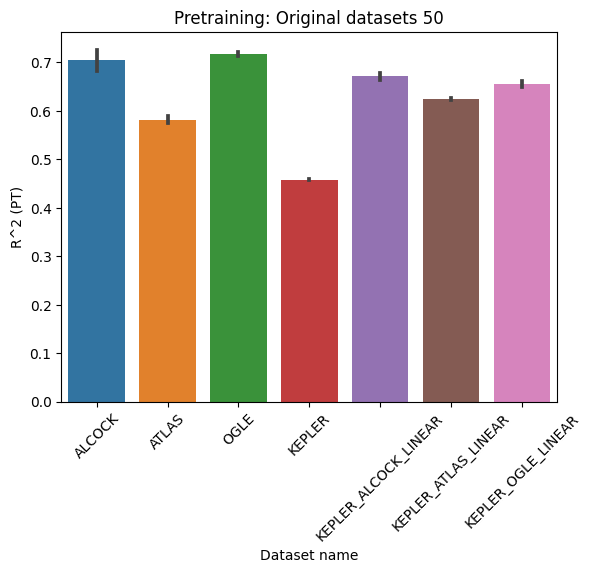

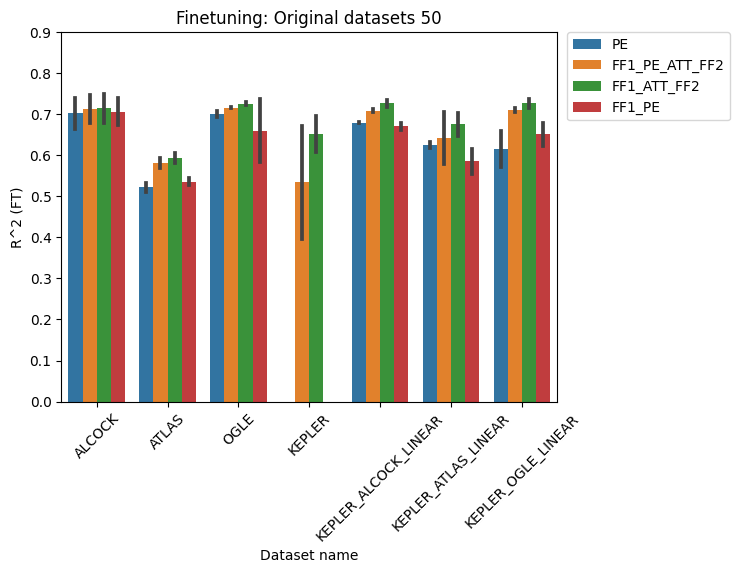

In [27]:
x = 'Dataset name'
y = 'R^2 (PT)'
title = 'Pretraining: Original datasets {}'.format(subsets[0])

bar_plot_pt(final_datasets_al_at_og_500, x, y, title)

print("")

x = 'Dataset name'
y = 'R^2 (FT)'
title = 'Finetuning: Original datasets {}'.format(subsets[0])

bar_plot_ft(final_datasets_al_at_og_500, x, y, title)

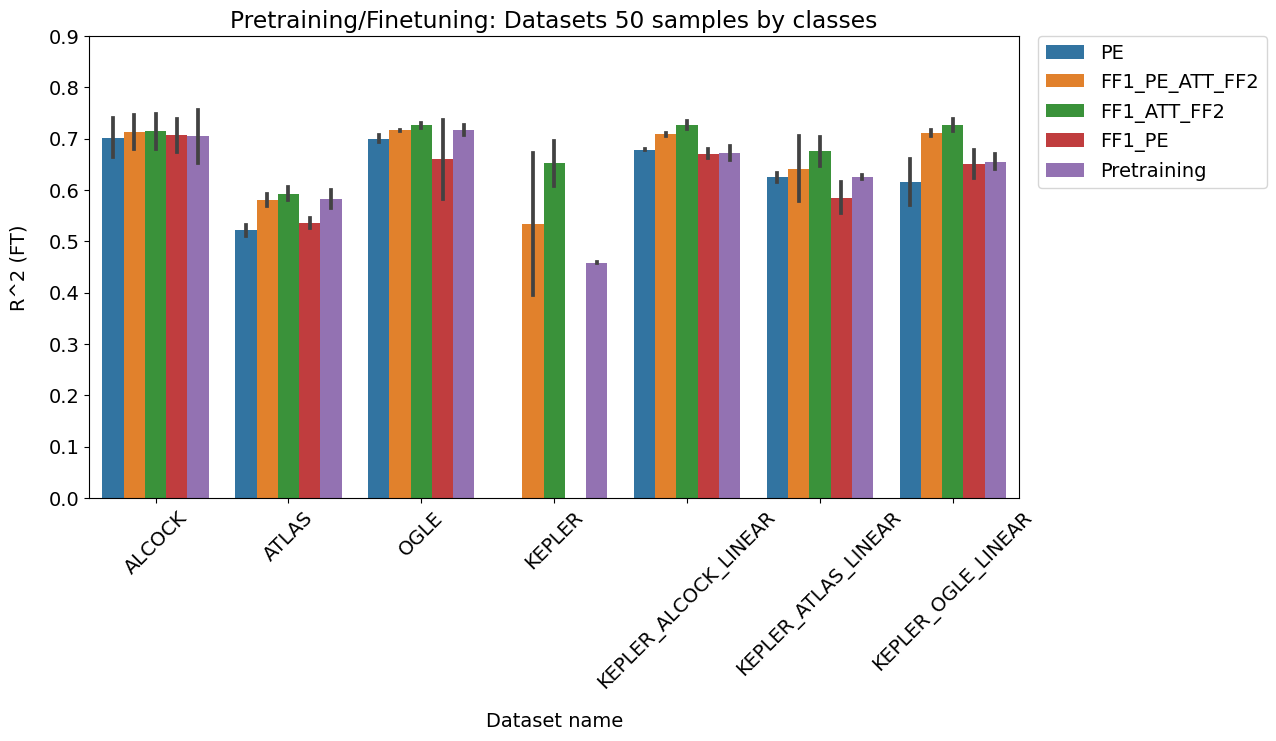

In [28]:
x = 'Dataset name'
y = 'R^2 (FT)'
title = 'Pretraining/Finetuning: Datasets {} samples by classes'.format(subsets[0])

from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 12, 6
rcParams.update({'font.size': 14})
rcParams['axes.labelpad'] = 14

bar_plot_ft(df_results_final, x, y, title, pt_ft=True)

In [46]:
1/(10000**(1/256))**2 / 50

0.019293232398223982

In [48]:
(1/(1000**(1/256))**2) / 50

0.018949270513107505

## Pretraining evaluated directly in the datasets

In [75]:
df_results_filtered = df_results[df_results['Dataset name'] != 'ATLAS']
df_results_filtered

,Time Mean,Δ R^2 Mean,Δ RMSE Mean,Time Std,Δ R^2 Std,Δ RMSE Std,Dataset name,Trainable layers
0,91.066089,-0.001906,-0.000573,15.077792,0.004831,0.001698,ALCOCK,PE
1,256.629807,0.001123,0.000276,50.374743,0.003685,0.000873,ALCOCK,FF1_PE_ATT_FF2
2,174.979159,0.006132,0.000700,68.466115,0.000856,0.000906,ALCOCK,FF1_ATT_FF2
3,81.779074,-0.001386,0.000028,13.378001,0.001935,0.000783,ALCOCK,FF1_PE
8,349.037878,-0.002915,0.000979,43.793981,0.049844,0.001599,OGLE,PE
9,1092.578019,0.130629,0.008232,366.608726,0.004473,0.000225,OGLE,FF1_PE_ATT_FF2
10,981.372653,0.127116,0.007790,112.541414,0.005090,0.000266,OGLE,FF1_ATT_FF2
11,432.006693,0.042958,0.002641,121.378258,0.047326,0.001348,OGLE,FF1_PE


In [18]:
df_results_filtered = df_results.copy()

/home/users/dmoreno2016/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/users/dmoreno2016/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/users/dmoreno2016/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/users/dmoreno2016/miniconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a futu

Text(0.5, 29.000000000000014, 'Training time')

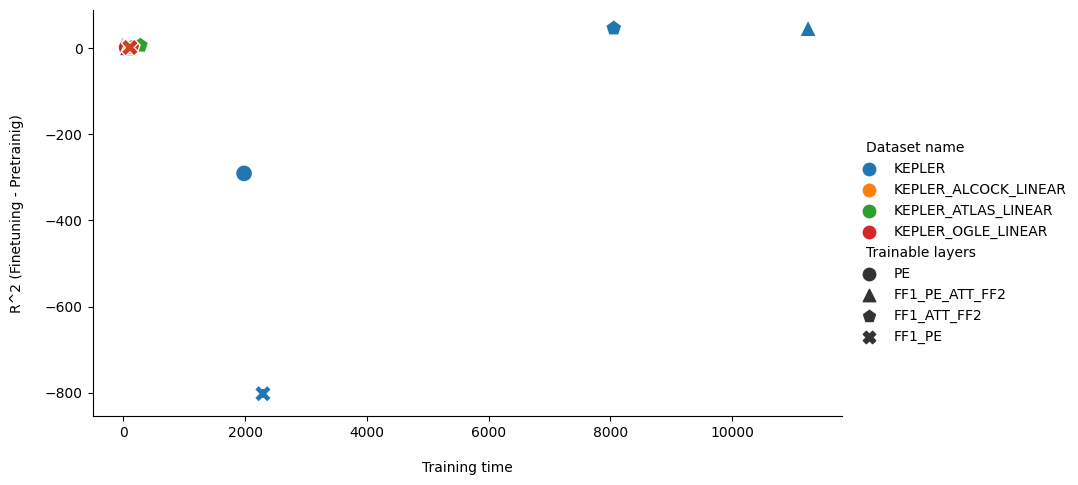

In [19]:
markers_set=['o', '^', 'p', 'X']


ax = sns.relplot(data=df_results_filtered, x='Time Mean', y=u'Δ R^2 Mean', hue='Dataset name', style='Trainable layers', s=150, height=4.8, aspect=1.8,
                 markers=markers_set)

markers, caps, bars = ax.ax.errorbar(df_results_filtered['Time Mean'], df_results_filtered[u'Δ R^2 Mean'],
                                     yerr=df_results_filtered[u'Δ R^2 Std'],
                                     #xerr=df_results['Time Std'],
                                     fmt='o',
                                     markersize=10,
                                     zorder=1, )

markers.set_markerfacecolor((1, 1, 0, 0.01))

for lh in ax._legend.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [80] 

plt.ylabel('R^2 (Finetuning - Pretrainig)', labelpad=15)
plt.xlabel('Training time', labelpad=15)